In [199]:
import pickle as pickle
import os
import pandas as pd
import torch
from functools import partial

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from collections import defaultdict, Counter
from wordcloud import WordCloud, STOPWORDS
from konlpy.tag import Mecab
m = Mecab()
from sklearn.model_selection import train_test_split

In [331]:
def preprocessing_dataset(dataset):
    train_subject_entity = []
    train_object_entity = []
    train_subject_type = []
    train_object_type = []
    val_subject_entity = []
    val_object_entity = []
    val_subject_type = []
    val_object_type = []

    for train in train_examples['train']:
        train_subject_entity.append(train['subject_entity']['word'])
        train_object_entity.append(train['object_entity']['word'])
        train_subject_type.append(train['subject_entity']['type'])
        train_object_type.append(train['object_entity']['type'])
    
    for val in train_examples['valid']:
        val_subject_entity.append(val['subject_entity']['word'])
        val_object_entity.append(val['object_entity']['word'])
        val_subject_type.append(val['subject_entity']['type'])
        val_object_type.append(val['object_entity']['type'])
        
        
    train_dataset = pd.DataFrame({'id':dataset['train']['guid'], 'sentence':dataset['train']['sentence'],
                                  'subject_entity':train_subject_entity,'object_entity':train_object_entity,
                                  'subject_type':train_subject_type, 'object_type':train_object_type,'source':dataset['train']['source'], 
                                  'label':dataset['train']['label'], 'text': dataset['train']['text']})
    
    val_dataset = pd.DataFrame({'id':dataset['valid']['guid'], 'sentence':dataset['valid']['sentence'],
                                  'subject_entity':val_subject_entity,'object_entity':val_object_entity,
                                  'subject_type':val_subject_type, 'object_type':val_object_type,'source':dataset['valid']['source'], 
                                  'label':dataset['valid']['label'], 'text': dataset['valid']['text']})
    
    out_dataset = pd.concat([train_dataset, val_dataset])
    out_dataset['id'] = out_dataset['id'].map(int)
    return out_dataset.sort_values(['id']).reset_index(drop=True)

In [254]:
markers = dict(
    subject_start_marker="<subj>",
    subject_end_marker="</subj>",
    object_start_marker="<obj>",
    object_end_marker="</obj>",
)
mark_entity_spans = partial(_mark_entity_spans, **markers)

In [275]:
from typing import Dict, Tuple, List, Any


# create_example
def _mark_entity_spans(examples,
                      subject_start_marker: str, subject_end_marker: str,
                      object_start_marker: str, object_end_marker: str):

    def _mark_entity_spans(
        text: str, 
        subject_range=Tuple[int, int], 
        object_range=Tuple[int, int]
    ) -> str:
        """ Adds entity markers to the text to identify the subject/object entities.
        Args:
            text: Original sentence
            subject_range: Pair of start and end indices of subject entity
            object_range: Pair of start and end indices of object entity
        Returns:
            A string of text with subject/object entity markers
        """
        if subject_range < object_range:
            segments = [
                text[: subject_range[0]],
                subject_start_marker,
                text[subject_range[0] : subject_range[1] + 1],
                subject_end_marker,
                text[subject_range[1] + 1 : object_range[0]],
                object_start_marker,
                text[object_range[0] : object_range[1] + 1],
                object_end_marker,
                text[object_range[1] + 1 :],
            ]
        elif subject_range > object_range:
            segments = [
                text[: object_range[0]],
                object_start_marker,
                text[object_range[0] : object_range[1] + 1],
                object_end_marker,
                text[object_range[1] + 1 : subject_range[0]],
                subject_start_marker,
                text[subject_range[0] : subject_range[1] + 1],
                subject_end_marker,
                text[subject_range[1] + 1 :],
            ]
        else:
            raise ValueError("Entity boundaries overlap.")

        marked_text = "".join(segments)

        return marked_text
    
    subject_entity = examples["subject_entity"]
    object_entity = examples["object_entity"]
    
    text = _mark_entity_spans(
        examples["sentence"],
        (subject_entity["start_idx"], subject_entity["end_idx"]),
        (object_entity["start_idx"], object_entity["end_idx"]),
    )
    return {"text": text}

## Load Dataset

In [214]:
with open('dict_label_to_num.pkl', 'rb') as f:
    dict_label_to_num = pickle.load(f)

In [273]:
from datasets import load_dataset

data = load_dataset("jinmang2/load_klue_re", script_version="v1.0.1b")

Reusing dataset klue_re (/opt/ml/.cache/huggingface/datasets/klue_re/re/1.0.1/72db5b4f9111ca3106d23ecec67a53f750c70b70b32c5512f925baac3b39a0de)


  0%|          | 0/3 [00:00<?, ?it/s]

## Preprocessing Data

In [276]:
train_examples = data.map(mark_entity_spans)

Loading cached processed dataset at /opt/ml/.cache/huggingface/datasets/klue_re/re/1.0.1/72db5b4f9111ca3106d23ecec67a53f750c70b70b32c5512f925baac3b39a0de/cache-1b60102a6a3dc2ac.arrow
Loading cached processed dataset at /opt/ml/.cache/huggingface/datasets/klue_re/re/1.0.1/72db5b4f9111ca3106d23ecec67a53f750c70b70b32c5512f925baac3b39a0de/cache-0f19d2ecbd908cf9.arrow
Loading cached processed dataset at /opt/ml/.cache/huggingface/datasets/klue_re/re/1.0.1/72db5b4f9111ca3106d23ecec67a53f750c70b70b32c5512f925baac3b39a0de/cache-6ca47e8cb16bae22.arrow


In [335]:
pd_dataset = preprocessing_dataset(train_examples)
pd_dataset

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label,text
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,비틀즈,조지 해리슨,ORG,PER,wikipedia,0,〈Something〉는 <obj>조지 해리슨</obj>이 쓰고 <subj>비틀즈</...
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,민주평화당,대안신당,ORG,ORG,wikitree,0,호남이 기반인 바른미래당·<obj>대안신당</obj>·<subj>민주평화당</sub...
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,광주FC,한국프로축구연맹,ORG,ORG,wikitree,20,K리그2에서 성적 1위를 달리고 있는 <subj>광주FC</subj>는 지난 26일...
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,아성다이소,박정부,ORG,PER,wikitree,1,균일가 생활용품점 (주)<subj>아성다이소</subj>(대표 <obj>박정부</o...
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,요미우리 자이언츠,1967,ORG,DAT,wikipedia,0,<obj>1967</obj>년 프로 야구 드래프트 1순위로 <subj>요미우리 자이...
...,...,...,...,...,...,...,...,...,...
32465,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,유기준,부산 서구·동구,PER,LOC,wikitree,6,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...
32466,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...",최시형,손병희,PER,PER,wikipedia,14,"법포는 다시 <subj>최시형</subj>, 서병학, <obj>손병희</obj> 직..."
32467,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,완도군,신우철,ORG,PER,wikitree,1,<subj>완도군</subj>(군수 <obj>신우철</obj>)이 국토교통부에서 실...
32468,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...",JTBC,중앙홀딩스,ORG,ORG,wikipedia,0,"중앙일보, <subj>JTBC</subj> 회장을 지낸 이후 <obj>중앙홀딩스</..."


In [337]:
display(pd_dataset.subject_type.value_counts())
display(pd_dataset.object_type.value_counts())

PER    16786
ORG    15684
Name: subject_type, dtype: int64

PER    9788
ORG    9346
POH    5113
DAT    4249
LOC    3561
NOH     413
Name: object_type, dtype: int64

In [338]:
pd_dataset.source.unique()

array(['wikipedia', 'wikitree', 'policy_briefing'], dtype=object)

/tmp/ipykernel_10633/1845487152.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(group_cnt.index, fontsize=11, fontweight='semibold', rotation=90)


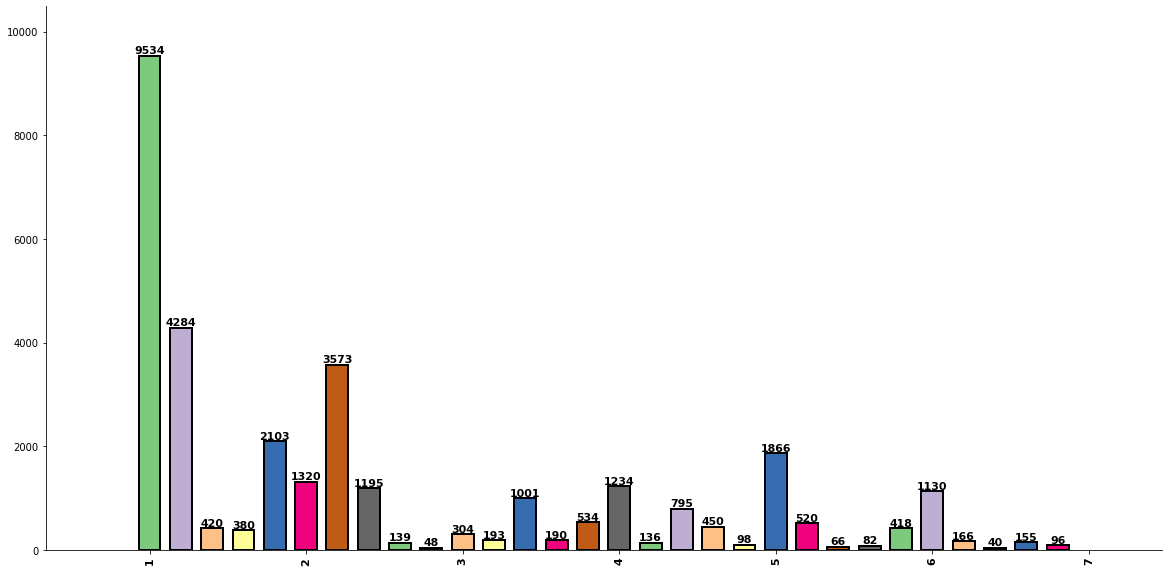

In [339]:
palette = sns.color_palette("Accent")
group_cnt = pd_dataset['label'].value_counts().sort_index()

fig, ax = plt.subplots(1, 1, figsize=(20, 10))


ax.bar(group_cnt.index, group_cnt,
       width=0.7,
       edgecolor='black',
       linewidth=2,
       color=palette,
       zorder=10
      )
ax.set_xticklabels(group_cnt.index, fontsize=11, fontweight='semibold', rotation=90)
ax.margins(0.1, 0.1)

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)


for idx, value in zip(group_cnt.index, group_cnt):
    ax.text(idx, value+5, s=value,
                 ha='center', 
                 fontweight='semibold',
                 fontsize=11,
                 va='bottom'
                )
        
plt.show()

## UNK 처리 파악

In [340]:
from transformers import AutoModel, AutoTokenizer, BertTokenizer

In [341]:
MODEL_NAME = "klue/roberta-large"

In [342]:
model = AutoModel.from_pretrained(MODEL_NAME)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/opt/conda/lib/python3.8/site-packages/transformers/configuration_utils.py:336: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(
Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be 

In [343]:
unknown = set()

In [220]:
pd_dataset[pd_dataset.subject_entity == " '스페인'"]

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
440,440,21세의 앙갱 공작 루이가 지휘하는 프랑스군은 재빠르게 스페인 군의 움직임에 반응하...,'스페인','6,'ORG','NOH',wikipedia,no_relation
6350,6350,"이 작품은 스페인 국왕 펠리페 4세의 마드리드 궁전에 있는 큰 방을 그린 것이며, ...",'스페인','마드리드','ORG','POH',wikipedia,no_relation
13313,13313,"얼마 뒤 아브드 엘 크림은 아누알(Annual)의 스페인 보병대를 급습하여 단 3,...",'스페인','8,'ORG','NOH',wikipedia,no_relation
13502,13502,"마드리드 또는 발렌시아가 스페인 후보일 것이라는 소문이 있었으나, 스페인은 끝내 바...",'스페인','마드리드','ORG','ORG',wikipedia,org:members
19663,19663,"약 27,000명에 달하는 합스부르크 가문의 스페인-신성로마제국 연합군은 아르덴(A...",'스페인','27,'ORG','NOH',wikipedia,no_relation
20436,20436,바이에른 뮌헨의 감독으로 부임한 이후에도 분데스리가 3연패를 달성하면서 바르셀로나에...,'스페인','마드리드','ORG','ORG',wikipedia,org:place_of_headquarters
21811,21811,디에고 다 실바 코스타 또는 지에구 다 시우바 코스타는 브라질 출신 스페인 축구 선...,'스페인','마드리드','ORG','ORG',wikipedia,org:place_of_headquarters
21821,21821,"얼마 뒤 아브드 엘 크림은 아누알(Annual)의 스페인 보병대를 급습하여 단 3,...",'스페인','3,'ORG','NOH',wikipedia,no_relation
24447,24447,이 경기 승리로 레알 마드리드는 스페인 리그 역사상 최초로 단일 시즌 승점 100점...,'스페인','마드리드','ORG','ORG',wikipedia,no_relation
25703,25703,"그는 등번호 14번을 부여 받았고, 마드리드에서 열린 1-2로 패배한 스페인과의 친...",'스페인','마드리드','ORG','LOC',wikipedia,org:members


In [195]:
for i, rows in pd_dataset.iterrows():
    e1, e2 = rows['subject_entity'], rows['object_entity']
    
    if tokenizer.tokenize(e1)[0] == "[UNK]":
        unknown.add(e1)
    if tokenizer.tokenize(e2)[0] == "[UNK]":
        unknown.add(e2)


IndexError: list index out of range

## hierarchical 파악

In [144]:
label_list = list(dict_label_to_num.keys())

### org:top_members/employees

In [150]:
pd_dataset.query('label == "org:top_members/employees" & object_type != "PER" & object_type != "POH"')
# 30879 index의 경우 object_type은 제대로 되어있고 label이 잘못된 케이스

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
2739,2739,도쿠가와 씨는 1800년대 중반에 에도 막부가 문을 닫을 때까지 미토를 직접 통치하였다.,'에도 막부','도쿠가와',ORG,ORG,wikipedia,org:top_members/employees
4197,4197,재단법인 오뚜기함태호재단은 6월 27일 인천 송도컨벤시아에서 ‘제20회 오뚜기 함태...,'오뚜기','함태호',ORG,ORG,wikitree,org:top_members/employees
4428,4428,쾰른의 브루노(1130년 - 1101년 10월 6일)은 로마 가톨릭교회 성인이자 수...,'로마 가톨릭교회','쾰른의 브루노',ORG,LOC,wikipedia,org:top_members/employees
5053,5053,"소울 컴퍼니의 Kebee와 함께 이룬 프로젝트 앨범, ""Eluphant Bakery...",'소울 컴퍼니','Kebee',ORG,ORG,wikipedia,org:top_members/employees
5955,5955,횡성 고씨 고구려 왕실종친회는 2015년 대한민국 통계청 인구조사에서 약 1만명 조...,'고구려 왕실종친회','횡성 고씨',ORG,LOC,wikipedia,org:top_members/employees
8297,8297,1945년 9월 호찌민은 하노이를 수도로 하여 베트남 민주 공화국(북베트남)의 독립...,'베트남','호찌민',ORG,LOC,wikipedia,org:top_members/employees
9233,9233,기원전 27년에 원로원으로부터 아우구스투스의 칭호를 받으며 임페라토르로 등극한 옥타...,'로마 제국','원로원',ORG,ORG,wikipedia,org:top_members/employees
10601,10601,재단법인 오뚜기함태호재단은 10월 24일 제주 국제컨벤션센터에서 ‘제21회 오뚜기 ...,'오뚜기','함태호',ORG,ORG,wikitree,org:top_members/employees
10854,10854,"이 제의는 소위 대박을 내었고, 리버풀 FC의 악명높은 안필드 스피온 콥 스탠드의 ...",'리버풀 FC','안필드',ORG,LOC,wikipedia,org:top_members/employees
11002,11002,한국해양대학교 제8대 도덕희 총장 취임식이 12월 2일 오후 2시 대학 대강당에서 ...,'한국해양대학교','도덕희',ORG,NOH,wikitree,org:top_members/employees


### org:members

In [242]:
pd_dataset.query('label == "org:members" & object_type != "ORG" & object_type != "POH"')
# LOC 말고도 다른 object도 있지만 LOC를 어떻게 처리할지 고민

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
13,13,뉴질랜드 1차산업부 생물보안 대변인 캐서린 더시 박사는 과일파리를 잡기 위해 오클랜...,뉴질랜드,오클랜드,ORG,LOC,wikitree,org:members
135,135,"한편, 러시아의 경우에도 러시아 측의 조치로 인해 올 3월부터 인천-모스크바 간 정...",러시아,모스크바,ORG,LOC,policy_briefing,org:members
364,364,1999년에는 토론토에 본사를 둔 CPR계 캐나다 태평양 호텔 & 리조트 사(CPH...,캐나다,토론토,ORG,LOC,wikipedia,org:members
588,588,"칼마르 동맹(Kalmarunionen, 1397년 ~ 1523년) 또는 스칸디나비아...",칼마르 동맹,덴마크,ORG,LOC,wikipedia,org:members
806,806,"세르게이 니콜라예비치 이그나셰비치(1979년 7월 14일, 러시아 SFSR 모스크바...",러시아,모스크바,ORG,LOC,wikipedia,org:members
...,...,...,...,...,...,...,...,...
31348,31348,"그는 헝가리 1부리그, 부다페스트를 연고로 하는 셰펠 SC에서 준수한 활약을 하였다.",헝가리,부다페스트,ORG,LOC,wikipedia,org:members
31661,31661,그러나 웨일스가 잉글랜드 왕국에 합병 이후에도 웨일스 법은 계속 유지되었다.,잉글랜드 왕국,웨일스,ORG,LOC,wikipedia,org:members
31865,31865,"텍사스 대학교 오스틴 재학 중, 캠퍼스에서 10명의 가장 아름다운 미인들 10명 중...",텍사스,오스틴,ORG,LOC,wikipedia,org:members
32409,32409,중세 세르비아 공국의 수도였던 스타리라스(Stari Ras)가 사라진 뒤에 설립된 ...,중세 세르비아 공국,스타리라스,ORG,LOC,wikipedia,org:members


In [243]:
pd_dataset.query('label == "org:members" & object_type != "ORG" & object_type != "POH" & object_type != "LOC"')
# LOC 말고도 다른 object도 있지만 LOC를 어떻게 처리할지 고민

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
3118,3118,"이후 태연, 써니, 효연, 유리, 윤아로 소녀시대의 두 번째 유닛 그룹 소녀시대-O...",소녀시대,소녀시대-Oh!GG,PER,PER,wikipedia,org:members
18065,18065,2001년 3월 28일부터 2003년 12월 24일까지 바실리예프는 러시아 내무부 ...,러시아,모스크바,ORG,DAT,wikipedia,org:members
19704,19704,1990년에는 올랭피크 드 마르세유로 이적했고 1990-91 시즌에서는 올랭피크 드...,올랭피크 드 마르세유,리그 1,ORG,NOH,wikipedia,org:members
23361,23361,"펠릭스클레르 리델(Félix-Clair Ridel, 1830년 7월 7일 ~ 188...",천주교 조선교구,대교구,ORG,NOH,wikipedia,org:members
29766,29766,당시 비틀즈의 판권을 가지고 있는 애플 레코드가 음악에 대한 모든 상표권을 가지고 ...,애플 레코드,비틀즈,ORG,PER,wikipedia,org:members
30202,30202,비록 ICOMOS의 권고 시점에서 기준(4)의 적용은 부정되었고 세계문화유산 위원회...,문화유산,히라이즈미,ORG,PER,wikipedia,org:members


### org:product

In [164]:
pd_dataset.query('label == "org:product" & object_type != "POH"')
# 이건 대체로 POH가 되어야 하지 않을까

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
210,210,주거 브랜드인 삼부르네상스를 도시에 두고 있고 삼부토건사인 조정구에 의해 설립하였다.,'삼부토건','삼부르네상스',ORG,ORG,wikipedia,org:product
257,257,그는 “기업 측의 보수적인 가이던스를 참고해보면 올해 매출액 1조원은 최저 준”이라...,'삼성전자','LSI',ORG,ORG,wikitree,org:product
469,469,두 모바일 AP 모두 삼성전자 시스템 LSI 사업부의 14nm FinFET LPP ...,'삼성전자','LSI',ORG,ORG,wikipedia,org:product
765,765,특히 한국GM이 새한자동차 및 대우자동차 시절에 나왔던 대우 로얄 시리즈 중 로얄 ...,'한국GM','자동차',ORG,ORG,wikipedia,org:product
1452,1452,대우건설은 4일과 5일 양일간 경기 화성시 동탄역 푸르지오에서 '라이프 프리미엄 자...,'대우건설','푸르지오',ORG,LOC,wikitree,org:product
...,...,...,...,...,...,...,...,...
30650,30650,토요타 자동차는 동력 분할 변속기(PST)를 채택한 토요타 프리우스를 1997년 발...,'렉서스','토요타 자동차',ORG,ORG,wikipedia,org:product
31131,31131,"보아는 많은 브랜드 광고에 출연하였는데, 보아가 광고를 했었던 브랜드로는 올림푸스,...",'GM 대우','자동차',ORG,ORG,wikipedia,org:product
32083,32083,"1992년에는 한양공영과 기술제휴를 맺음으로서 대한민국 승강기 시장에 진출하였고, ...",'티센크루프','엘리베이터',ORG,ORG,wikipedia,org:product
32229,32229,화순군(군수 구충곤)은 17일 힐스테이트 화순의 건설사인 현대엔지니어링의 조영기 현...,'현대엔지니어링','힐스테이트',ORG,LOC,wikitree,org:product


### org:alternate_names

In [167]:
pd_dataset.query('label == "org:alternate_names" & object_type != "POH" & object_type != "ORG"')
# 대체 단어라 애매한 부분이 있다. 어지간하면 POH여야 하지 않을까

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
575,575,그 뒤 이하응이 흥선정과 도정에 봉해지면서 신인(慎人:정3품 종친처)과 신부인(慎夫...,'흥선군','이하응',ORG,PER,wikipedia,org:alternate_names
1800,1800,"이날 행사에는 배우 이서진, 엑소(EXO) 찬열, 에이핑크(Apink) 손나은, 모...",'Apink','에이핑크',ORG,PER,wikitree,org:alternate_names
1970,1970,지난 7일 그룹 '에이비식스(AB6IX)'가 첫 번째 정규 앨범을 발매했다.,'AB6IX','에이비식스',ORG,PER,wikitree,org:alternate_names
2285,2285,제주도는 2013년도부터 전국 최초 복지시설별로 다르게 적용되는 직급과 급여체계를 ...,'제주도','제주특별자치도',ORG,LOC,wikitree,org:alternate_names
3051,3051,"1947년 1월 제정된 중화민국 헌법이 같은 해 12월 25일부터 시행되면서, 국민...",'국민혁명군','중화민국 국군',ORG,LOC,wikipedia,org:alternate_names
3170,3170,국적 2위 항공사인 아시아나항공[020560]의 새 주인을 찾기 위한 매각 우선협상...,'아시아나항공','020560',ORG,NOH,wikitree,org:alternate_names
4460,4460,"도쿄도의 중심지로 일본의 수도의 기능을 대부분 가지고 있는 지역이며, 도쿄 도청이 ...",'도쿄 도','도쿄도',ORG,LOC,wikipedia,org:alternate_names
5820,5820,라젠발스포르트 라이프치히(RasenBallsport Leipzig e. V.)는 R...,'RB 라이프치히','RasenBallsport Leipzig e. V.',ORG,LOC,wikipedia,org:alternate_names
6324,6324,'미지수'는 설리가 속해있던 그룹 '에프엑스(f(x)(x))'를 나타내며 포근한 이...,'f(x)','에프엑스',ORG,PER,wikitree,org:alternate_names
6501,6501,프랑스는 안남의 후에를 수도로 삼은 응우옌 왕조(구엔 왕조)의 황권을 형식적으로는 ...,'구엔 왕조','응우옌 왕조',ORG,LOC,wikipedia,org:alternate_names


### org:place_of_headquarters

In [169]:
pd_dataset.query('label == "org:place_of_headquarters" & object_type != "LOC"')
# 지역 이름이 등장하는 경우에는 LOC로 바꾸는게 맞아 보임

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
441,441,1984년 5월 빌바오와의 코파 델 레이(스페인 국왕컵) 결승에서 마라도나는 집단 ...,'코파 델 레이','스페인',ORG,POH,wikipedia,org:place_of_headquarters
450,450,"그러나 1934년 일본 제국에 투항하였고, 일본군 헌병대의 특무조직인 간도협조회 본...",'일본군','일본 제국',ORG,ORG,wikipedia,org:place_of_headquarters
526,526,"스웨덴 해적당을 모델로 여러나라에서 해적당이 창당되었으며, 이들은 국제조직 해적당 ...",'해적당','스웨덴',ORG,ORG,wikipedia,org:place_of_headquarters
563,563,구단명은 당시 상파울루주에 있던 SC 인테르나시오나우와 자신들의 고향의 축구단인 F...,'인테르나치오날레','밀라노',ORG,ORG,wikipedia,org:place_of_headquarters
604,604,0:5로 대패하였지만 당시 경기를 지켜본 영국 언론이 '대한민국에서 가장 인상깊은 ...,'PSV 에인트호번','네덜란드',ORG,ORG,wikipedia,org:place_of_headquarters
...,...,...,...,...,...,...,...,...
32281,32281,"1965년 스토니브룩 대학교, 올버니 대학교, 버펄로 대학교와 함께 뉴욕주립대 시스...",'뉴욕주립대','뉴욕 주립 대학교 빙엄턴',ORG,ORG,wikipedia,org:place_of_headquarters
32304,32304,2010년 초 잉글랜드 프리미어리그의 번리와 사우디아라비아 프리미어리그의 알샤바브의...,'세리에 A','이탈리아',ORG,ORG,wikipedia,org:place_of_headquarters
32308,32308,"부산항만공사(BPA, 사장 남기찬)는 7일 부산 중구 중앙동 본사에서 베트남 하이퐁...",'하이퐁','베트남',ORG,ORG,wikitree,org:place_of_headquarters
32348,32348,경남대학교 LINC사업단(단장 강재관)은 5일 대전 컨벤션 센터에서 개최된 ‘제2회...,'경남대학교','대한민국',ORG,POH,wikitree,org:place_of_headquarters


In [269]:
pd_dataset.query('label == "org:place_of_headquarters"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
8,8,중공군에게 온전히 대항할 수 없을 정도로 약해진 국민당은 타이베이로 수도를 옮기는 ...,중화민국,타이베이,ORG,LOC,wikipedia,org:place_of_headquarters
85,85,강진 아르코공연연습센터는 전라남도 강진군 대구면 저두리 66번지에 위치해 있으며 단...,강진군,전라남도,ORG,LOC,wikipedia,org:place_of_headquarters
129,129,2007년 5월 30일 조선중앙통신사는 조선민주주의인민공화국의 국가인 애국가가 재편...,조선중앙통신사,조선민주주의인민공화국,ORG,LOC,wikipedia,org:place_of_headquarters
132,132,1972년 테헤란 대학교(법학)을 졸업한 뒤 영국 스코틀랜드의 글래스고 칼레도니언 ...,글래스고,스코틀랜드,ORG,LOC,wikipedia,org:place_of_headquarters
134,134,"1726년 상인의 아들로 스코틀랜드 에든버러에서 태어나, 에든버러 대학교에서 법률을...",에든버러 대학교,스코틀랜드 에든버러,ORG,LOC,wikipedia,org:place_of_headquarters
...,...,...,...,...,...,...,...,...
32348,32348,경남대학교 LINC사업단(단장 강재관)은 5일 대전 컨벤션 센터에서 개최된 ‘제2회...,경남대학교,대한민국,ORG,POH,wikitree,org:place_of_headquarters
32362,32362,1961년 스위스의 종합 식품회사 네슬레에서 우유 성분을 첨가하지 않고 완전히 식물...,네슬레,스위스,ORG,LOC,wikipedia,org:place_of_headquarters
32369,32369,이후 33인 중 유일하게 체포되지 않고 상하이로 망명을 떠나 대한민국 임시정부에 합...,대한민국 임시정부,상하이,ORG,LOC,wikipedia,org:place_of_headquarters
32410,32410,"1765년 네덜란드의 레이던 대학교로 유학하였고, 퍼햄 남작 휴 윌로비의 도움으로 ...",레이던 대학교,네덜란드,ORG,LOC,wikipedia,org:place_of_headquarters


### org:number_of_employees/members

In [171]:
pd_dataset.query('label == "org:number_of_employees/members" & object_type != "PER" & object_type != "NOH"')
# 깔끔

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label


### org:founded

In [173]:
pd_dataset.query('label == "org:founded" & object_type != "DAT"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label


### org:political/religious_affiliation

In [245]:
pd_dataset.query('label == "org:political/religious_affiliation" & object_type != "ORG"')
# 23495 index는 라벨링 자체가 잘못된것 같음. 그 외에 POH는 대체적으로 정치 이념과 유사해 보이며 바티칸은 LOC가 맞지만 이슬람은 LOC가 아니라 POH 처리 되어야 할 듯.
# 26777 index는 ORG가 맞지 않을까? 아무튼 DAT은 아님

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
50,50,1924년 11월 26일에는 정부 형태를 군주제에서 인민 공화제로 고쳐 국호를 몽골...,몽골 인민 공화국,공화제,ORG,POH,wikipedia,org:political/religious_affiliation
355,355,"캄푸치아 인민공화국, 에티오피아 인민 민주주의공화국, 남예멘이 공산주의를 버렸고, ...",몽골 인민 공화국,공산주의,ORG,POH,wikipedia,org:political/religious_affiliation
442,442,"폴란드에서 교복이라는 개념은 20세기 초반까지는 존재하지 않았지만, 폴란드에 공산주...",폴란드 인민 공화국,공산주의,ORG,POH,wikipedia,org:political/religious_affiliation
516,516,"레베데프는 과거 소비에트 연방의 대통령이었던 고르바초프와도 함께 일하고 있으며, 자...",노바야 가제타,자유주의,ORG,POH,wikipedia,org:political/religious_affiliation
1144,1144,"영국식 입헌군주제와 경제적 자유주의를 주창하던 진보당과, 개혁적 자유주의를 주창하던...",민주당,자유주의,ORG,POH,wikipedia,org:political/religious_affiliation
2172,2172,스웨덴은 1809년 헌법 개정으로 다시 입헌군주제와 의원 내각제를 채택하면서 의회의...,스웨덴,입헌군주제,ORG,POH,wikipedia,org:political/religious_affiliation
2848,2848,"모스크바 시간 기준 2015년 5월 12일, 넴초프가 한때 이끌었던 자유주의 성향의...",자유당,자유주의,ORG,POH,wikipedia,org:political/religious_affiliation
3020,3020,2012년 7월 실시된 대통령 선거에서 중도주의 정당인 제도혁명당(PRI)의 엔리케...,제도혁명당,중도주의,ORG,POH,wikipedia,org:political/religious_affiliation
3275,3275,"""첫 번째 뉴딜 정책""(1933년~1934년) 때에는 민주사회주의 정당인 미국 사회...",미국 사회당,민주사회주의,ORG,POH,wikipedia,org:political/religious_affiliation
4250,4250,프랑스 사회당 등이 속해 있는 사회민주주의 국제연합인 사회주의 인터내셔널(Socia...,사회당,사회민주주의,ORG,POH,wikipedia,org:political/religious_affiliation


### org:member_of

In [178]:
pd_dataset.query('label == "org:member_of" & object_type != "ORG" & object_type != "POH"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
42,42,"2008-09 시즌, 그는 페페의 10경기 출장 정지 징계로부터 수혜를 받은 선수로...",'세비야','스페인',ORG,LOC,wikipedia,org:member_of
49,49,때문에 개표가 최종 완료된 오전 8시 6분 중앙선거관리위원회에서 대통령 당선자 선언...,'중앙선거관리위원회','대한민국',ORG,LOC,wikipedia,org:member_of
206,206,이 시장은 “그동안 고양시는 지역불균형 · 자족시설 부족 · 넓은 그린벨트 지역 등...,'고양시','경기도',ORG,LOC,wikitree,org:member_of
243,243,"트래비스 재러드 블래클리(Travis Jarrod Blackley, 1982년 11...",'퍼시픽리그','일본 프로 야구',ORG,LOC,wikipedia,org:member_of
265,265,"1960년 8월 스페인 마드리드 대학에서 유학하여 2년 동안 신비신학, 고전문학을 ...",'마드리드','스페인',ORG,LOC,wikipedia,org:member_of
...,...,...,...,...,...,...,...,...
31621,31621,고양시는 복합적인 규제로 인해 양질의 일자리가 부족한 문제를 해결하고자 고양 일산테...,'고양시','경기도',ORG,LOC,wikitree,org:member_of
32100,32100,전라남도 나주시(시장 강인규)는 밭작물의 기계화율을 높여 농작업의 효율을 도모하기 ...,'나주시','전라남도',ORG,LOC,wikitree,org:member_of
32331,32331,공주시립웅진도서관은 충청남도 공주시 소재의 시립 도서관이다.,'공주시','충청남도',ORG,LOC,wikipedia,org:member_of
32355,32355,"순천시 해룡면마중물보장협의체(공동위원장 김병석, 해룡면장 채연석)는 평소보다 소외감...",'해룡면','순천시',ORG,LOC,wikitree,org:member_of


In [180]:
pd_dataset.query('label == "org:member_of" & object_type != "ORG" & object_type != "POH" & object_type != "LOC"')
# NOH, DAT으로 표기된 친구들 전부 POH나 ORG가 맞아보임 논의 필요.

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
544,544,"프랑스는 그 후로, 2001년과 2003년에 FIFA 컨페더레이션스컵 우승을 두 차...",'크로아티아','1998년 FIFA 월드컵',ORG,DAT,wikipedia,org:member_of
2699,2699,"이어지는 38년간 프랑스와 아디다스는 돈독한 파트너십을 구축하였는데, 이 기간동안 ...",'프랑스','UEFA 유로 1984',ORG,DAT,wikipedia,org:member_of
4685,4685,"2011년, 리그 1의 파리 생제르맹이 그를 €39.8M에 영입하였다.",'파리 생제르맹','리그 1',ORG,NOH,wikipedia,org:member_of
6650,6650,"이어지는 38년간 프랑스와 아디다스는 돈독한 파트너십을 구축하였는데, 이 기간동안 ...",'프랑스','1998년 FIFA 월드컵',ORG,DAT,wikipedia,org:member_of
11536,11536,"그는 리그 1의 FC 낭트 감독이었으나, 2009년 6월 2일에 클럽 보드진에 의해...",'FC 낭트','리그 1',ORG,NOH,wikipedia,org:member_of
17017,17017,2013년 8월 12일에 열린 SpVgg 그로이터 퓌르트와의 2. 분데스리가 경기에...,'그로이터 퓌르트','2. 분데스리가',ORG,NOH,wikipedia,org:member_of
18339,18339,2013년 8월 12일에 열린 SpVgg 그로이터 퓌르트와의 2. 분데스리가 경기에...,'SpVgg 그로이터 퓌르트','2. 분데스리가',ORG,NOH,wikipedia,org:member_of
19102,19102,데르비 드 프랑스 (Derby de France) 로도 알려진 르 클라시크는 프랑스...,'올랭피크 드 마르세유','리그 1',ORG,NOH,wikipedia,org:member_of
19637,19637,4.25체육단의 축구단은 1974년 도쿄 원정에서 일본 축구 국가대표팀을 4-0으로...,'4.25체육단','1부류축구련맹전',ORG,NOH,wikipedia,org:member_of
22594,22594,8강에서 바이에른은 리그 1에 속한 올랭피크 드 마르세유와 3월 28일에 1차전을 ...,'올랭피크 드 마르세유','리그 1',ORG,NOH,wikipedia,org:member_of


### org:dissolved

In [181]:
pd_dataset.query('label == "org:dissolved" & object_type != "DAT"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label


### org:founded_by

In [185]:
pd_dataset.query('label == "org:founded_by" & object_type != "ORG" & object_type != "PER"')
# 진짜 POH가 기준이 애매하다는 것을 느낌.
# 21482 index 이 친구는 왜 여기 있을까

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
6920,6920,"그러나 1125년, 요나라는 또다른 북방계 민족인 여진족이 세운 금나라와 송나라 연...",'금나라','여진족',ORG,POH,wikipedia,org:founded_by
14202,14202,한국해양대학교는 이시형 박사에 대해 한국해양대학교의 전신인 진해고등상선학교의 설립자...,'한국해양대학교','이시형 박사',ORG,POH,wikipedia,org:founded_by
19866,19866,1988년 전통주의자이자 성 비오 10세회의 창립자인 마르셀 르페브르 대주교가 성좌...,'성 비오 10세회','마르셀 르페브르 대주교',ORG,POH,wikipedia,org:founded_by
21482,21482,"1921년 하심가 출신인 압둘라 1세를 영입하여 트란스요르단을 세웠고, 제2차 세계...",'압둘라 1세','요르단',PER,LOC,wikipedia,org:founded_by
22569,22569,송나라는 연운 16주의 패권을 놓고 거란족이 세운 요나라(917년 ~ 1125년)와...,'요나라','거란족',ORG,POH,wikipedia,org:founded_by
26718,26718,"교회 전승에 따르면, 콥트 정교회는 1세기 중반(서기 42년경) 복음사가 마르코에 ...",'콥트 정교회','복음사가 마르코',ORG,POH,wikipedia,org:founded_by


In [176]:
label_list

['no_relation',
 'org:top_members/employees',
 'org:members',
 'org:product',
 'per:title',
 'org:alternate_names',
 'per:employee_of',
 'org:place_of_headquarters',
 'per:product',
 'org:number_of_employees/members',
 'per:children',
 'per:place_of_residence',
 'per:alternate_names',
 'per:other_family',
 'per:colleagues',
 'per:origin',
 'per:siblings',
 'per:spouse',
 'org:founded',
 'org:political/religious_affiliation',
 'org:member_of',
 'per:parents',
 'org:dissolved',
 'per:schools_attended',
 'per:date_of_death',
 'per:date_of_birth',
 'per:place_of_birth',
 'per:place_of_death',
 'org:founded_by',
 'per:religion']

In [100]:
pd_dataset.query('label == "per:place_of_death" & object_type != "LOC"')

,id,sentence,subject_entity,object_entity,subject_type,object_type,source,label
146,146,후지와라노 쇼시/다마코(1101년 - 1145년 9월 10일)은 헤이안 시대 도바 ...,'다카쿠라 천황','고시라카와 천황','PER','PER',wikipedia,per:parents
219,219,김대중은 1924년 1월 6일에 전라남도 신안에서 아버지 김운식과 어머니 장수금 사...,'김대중','어머니 장수금','PER','POH',wikipedia,per:parents
229,229,자의왕후는 문무왕과의 사이에서 소명태자와 훗날 신문왕이 되는 정명태자를 낳았다.,'신문왕','문무왕','PER','PER',wikipedia,per:parents
476,476,"후일 이스마일 2세라 알려질 이스마일 미르자는 밤, 타흐마스프 1세의 둘째 아들로 ...",'이스마일 2세','타흐마스프 1세','PER','PER',wikipedia,per:parents
529,529,"송갑조, 김장생의 문인으로 그 뒤로 송시열은 아버지 송갑조, 사계 김장생, 김장생의...",'송시열','송갑조','PER','PER',wikipedia,per:parents
...,...,...,...,...,...,...,...,...
32200,32200,페르난도 1세는 죽을 때 여러 자식들에게 왕국을 나누어주면서 둘째 아들 알폰소 6세...,'알폰소 6세','페르난도 1세','PER','PER',wikipedia,per:parents
32202,32202,1714년 루이 14세가 죽고 난 뒤에는 프랑수아즈도 궁에서 물러났고 어린 루이 1...,'루이 15세','루이 14세','PER','PER',wikipedia,per:parents
32246,32246,"국보와 보물로는 아래와 같은 것들이 있으며, 이것 외에도 흥선대원군의 아버지인 남연...",'흥선대원군','남연군','PER','LOC',wikipedia,per:parents
32266,32266,"조영길의 딸로, 이름은 봉가이(鳳加伊)이다.",'봉가이','조영길','PER','PER',wikipedia,per:parents
